In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from scipy.stats import norm

In [2]:
def trajectory2cluster_random(trajectories, nb_cluster):
    traj_cluster = pd.Series(data=np.random.randint(nb_cluster, size=trajectories.shape[0]),
                         index=trajectories, dtype=float)
    return traj_cluster

In [3]:
def samecluster(traj_cluster):
    """ For each pair of trajectories return whether they belong to same cluster or not
    """
    trajectories = traj_cluster.index
    pairs_traj = [p for p in combinations(trajectories,2)]
    same_cluster = pd.Series(index=pd.MultiIndex.from_tuples(pairs_traj),
                             data=False) #By default they are not in the same cluster
    for (s,e) in pairs_traj:
        if traj_cluster.loc[s] == traj_cluster.loc[e]:
            # Same cluster
            same_cluster.loc[s,e] = True
    return same_cluster

In [4]:
def get_color_gradient(series=None,nbtrials=None, cmap=plt.get_cmap('viridis')):
    if nbtrials is not None:
        series= pd.Series(index=np.arange(0, nbtrials))
        series[:] = np.linspace(0, 1, series.shape[0])

    normalised_values = series.values.copy()
    # substract offset from values, so the smallest one is zero
    normalised_values -= normalised_values.min()
    # all values are zero and have the same value
    if normalised_values.max() > 0:
        #raise ValueError('series.values are constant')
        # actually normalize the values
        normalised_values = normalised_values / normalised_values.max()
    colors = cmap(normalised_values)
    # create the dataframe from color
    df_colors = pd.DataFrame(
        data=colors, index=series.index, columns=['r', 'g', 'b', 'a'])

    # Create data for colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap,
                               norm=plt.Normalize(
                                   vmin=series.values.min(),
                                   vmax=series.values.max()))
    # fake up the array of the scalar mappable. Urgh...
    sm._A = []
    
    return df_colors, sm

# Prepare and load necessary files

In [5]:
key_template = 'traj_coeff_{}'
hdf_file = 'data_all_resampled.hdf'

conditions = pd.read_hdf(hdf_file, key='conditions')
conditions.head()

BeeID  Trial Condition         Filename  keep
0    33      5         0  20191028_113207     1
1    20      7         0  20191028_141719     1
2    20      8         0  20191028_142540     1
3    33      7         0  20191028_153803     1
4    33      8         0  20191029_095201     1

In [6]:
all_clusters = dict()

for k in range(2,11):
    all_clusters['K{}'.format(k)] = dict()
    
    for i in range(2,12):
        all_clusters['K{}'.format(k)]['C{}'.format(i)] = pd.read_csv('results/M3C/resampStab/C{}/res_all_annon_C{}_K{}.csv'.format(i,i,k), index_col=0)

In [7]:
def change_idx(df):
    clusters= []
    df_sorted = df.sort_index()
    newArray = pd.DataFrame(data=df_sorted, index=df_sorted.index, columns=['consensuscluster'])
    
    
    for i in range(0, len(df_sorted)):
        new_idx = '_'.join(df_sorted.index[i].split('_')[2:])
        newArray.loc[df_sorted.index[i], 'trajectories'] = new_idx
        
        cluster = df_sorted.loc[df_sorted.index[i]]
        clusters.append(cluster)
        
    newArray = newArray.reindex(newArray.loc[:, 'trajectories'])
    newArray.loc[:,'consensuscluster'] = clusters
    newArray = newArray.drop('trajectories', axis=1)
       
    return newArray

In [8]:
# to get rid of the coefficient in the filename
alltraj = []

for jj in range(0, len(all_clusters['K{}'.format(k)]['C6'].index)):
    new_idx = '_'.join(all_clusters['K{}'.format(k)]['C6'].index[jj].split('_')[2:])
    alltraj.append(new_idx)

# Cluster check

In [9]:
trajectories = np.array(alltraj)
all_conditions = dict() 

for k in range(2,11):
    print(k)
    all_conditions['K{}'.format(k)] = pd.DataFrame()
    
    for rc in range(2,12): 
        tempCluster = all_clusters['K{}'.format(k)]['C{}'.format(rc)].loc[:, 'consensuscluster']         
        traj_cluster = change_idx(tempCluster)
        traj_cluster = traj_cluster.loc[:,'consensuscluster']
        temp = samecluster(traj_cluster)
        
        all_conditions['K{}'.format(k)].loc[:, 'C{}'.format(rc)] = temp
                                 

2
3
4
5
6
7
8
9
10


In [10]:
precision_scores = pd.DataFrame()

for k in range(2,11):
    y_true = all_conditions['K{}'.format(k)].loc[:, 'C6']

    for rc in range(2,12):
        y_pred = all_conditions['K{}'.format(k)].loc[:, 'C{}'.format(rc)]
        precision_scores.loc['C{}'.format(rc), 'K{}'.format(k)] = precision_score(y_true, y_pred)

In [11]:
precision_scores

K2        K3        K4        K5        K6        K7        K8  \
C2   1.0  1.000000  0.984520  0.982578  0.981366  1.000000  1.000000   
C3   1.0  1.000000  0.984520  0.982578  0.981366  1.000000  1.000000   
C4   1.0  1.000000  0.984520  0.982578  0.981366  1.000000  1.000000   
C5   1.0  1.000000  0.984520  0.982578  0.981366  1.000000  1.000000   
C6   1.0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
C7   1.0  1.000000  1.000000  1.000000  1.000000  0.927103  0.932927   
C8   1.0  1.000000  1.000000  1.000000  1.000000  0.976059  0.978088   
C9   1.0  1.000000  0.984520  0.982578  1.000000  0.927103  0.932927   
C10  1.0  1.000000  1.000000  1.000000  1.000000  0.878505  0.910204   
C11  1.0  0.993146  0.989627  0.988318  0.987500  0.908772  0.889286   

           K9       K10  
C2   1.000000  1.000000  
C3   0.895652  1.000000  
C4   1.000000  1.000000  
C5   1.000000  1.000000  
C6   1.000000  1.000000  
C7   1.000000  0.916244  
C8   0.975771  0.952607  
C9   0.925676  0.916244  
C10  0.900452  0.887755  
C11  0.945455  0.938462

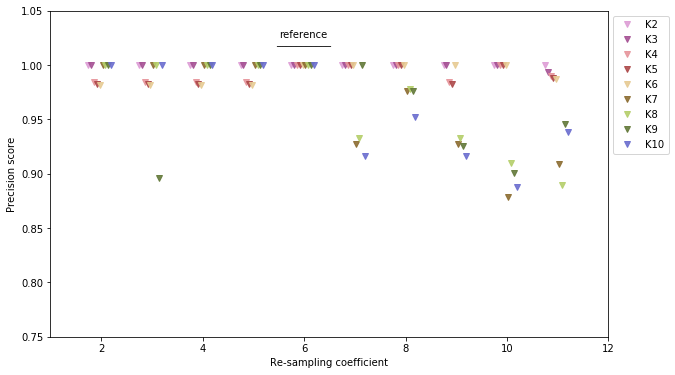

In [26]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
labels = ['K2', 'K3', 'K4', 'K5', 'K6',
          'K7', 'K8', 'K9', 'K10']
critVals = []

cmap = plt.get_cmap('tab20b_r')
df_colors, sm = get_color_gradient(nbtrials=10, cmap=cmap)

shift = np.linspace(-0.25, 0.25, 10)

for k in range(2,11):

    ax.plot(np.arange(2,12)+shift[k-2], precision_scores.loc[:,'K{}'.format(k)], 'v', color=df_colors.iloc[k-2], alpha=0.9)
    
    crit = np.percentile(precisionScore_random.loc[:,'K{}'.format(k)], 95)
    critVals.append(crit)
    
maxCrit = max(critVals)    
#ax.hlines(maxCrit, xmin=1, xmax=12, color='black', linestyles='dashed', alpha=0.6) 
    
ax.set_xlim([1, 12])
ax.set_ylim([0.75,1.05])
ax.legend(labels, loc='upper left', bbox_to_anchor=(1,1), ncol=1, fancybox=True)
ax.set_xlabel('Re-sampling coefficient')
ax.set_ylabel('Precision score')

ax.text(5.5,1.025, 'reference')
ax.text(5.45,1.02, '___________')


#fig.savefig('figures/resampling_precision_2.png')

## Random assignment

In [13]:
precisionScore_random = pd.DataFrame(index=np.arange(0,100),
                                     columns=['K2', 'K3', 'K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'K10'])
trajectories = np.array(alltraj)

In [14]:
for k in range(2,11):
    
    for i in range(0,100):
        ass = trajectory2cluster_random(trajectories, k)
        ass2 = samecluster(ass)

        y_pred = ass2
        score = precision_score(y_true, y_pred)
        precisionScore_random.loc[i, 'K{}'.format(k)] = score

In [15]:
precisionScore_random

K2        K3        K4         K5        K6         K7         K8  \
0    0.11943  0.150651  0.129762   0.130303  0.117754   0.115308  0.0962963   
1   0.117053  0.117329  0.133487  0.0995608  0.120339   0.106557   0.122892   
2   0.117053  0.118174    0.1052   0.124251  0.103448   0.122841   0.140097   
3   0.116002  0.126685  0.110852   0.130501  0.113074  0.0995851   0.104513   
4   0.120332  0.132552     0.125   0.119534  0.112339   0.122841   0.123153   
..       ...       ...       ...        ...       ...        ...        ...   
95   0.12656  0.107286  0.122328   0.131298   0.10302      0.092   0.131841   
96  0.117961  0.125336  0.145029    0.12766  0.145191   0.122056   0.111888   
97  0.121212  0.132313  0.135006   0.118619  0.132727   0.130901   0.128261   
98   0.11806  0.120859  0.114078    0.14645  0.111111   0.111554   0.115556   
99  0.124926  0.111011  0.131855    0.11396  0.135036   0.104034   0.114094   

          K9        K10  
0    0.12973   0.108504  
1   0.120092   0.106061  
2   0.105528   0.131285  
3   0.128866  0.0974843  
4   0.120603   0.110497  
..       ...        ...  
95  0.116625   0.143617  
96  0.129032    0.09375  
97  0.148459   0.121212  
98  0.123737   0.122699  
99  0.106849   0.108359  

[100 rows x 9 columns]

In [18]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

/home/agonsek/.virtualenvs/proj-ClutteredRoutes/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


2
3
4
5
6
7
8
9
10


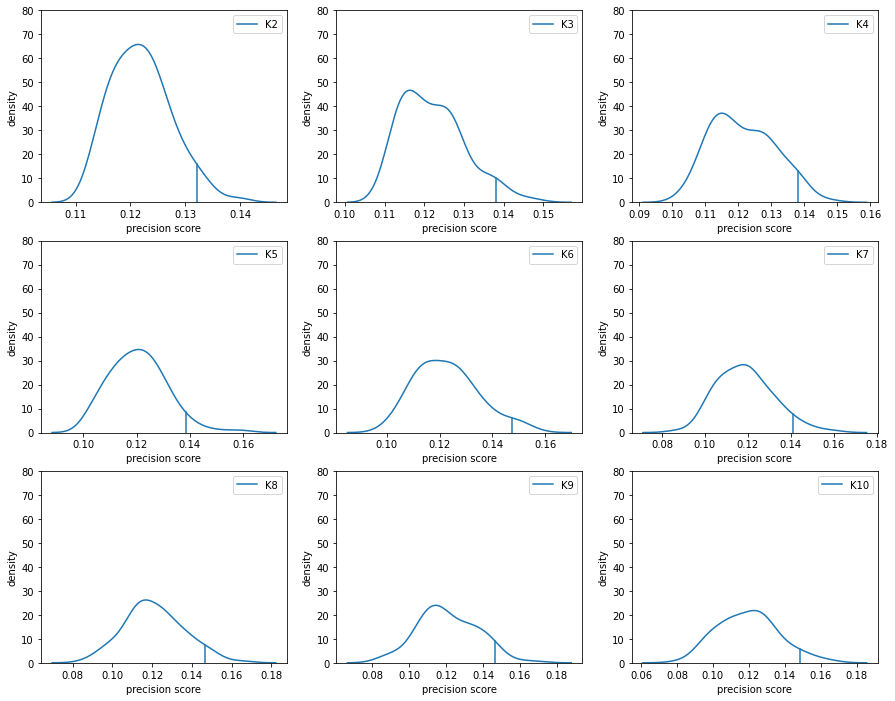

In [21]:
import seaborn as sns
fig, ax = plt.subplots(3,3, figsize=(15,12))
ax = ax.flatten()

cmap = plt.get_cmap('tab20b_r')
df_colors, sm = get_color_gradient(nbtrials=9, cmap=cmap)

for k in range(2,11):
    print(k)
    plotdata = sns.distplot(precisionScore_random.loc[:,'K{}'.format(k)], hist=False, label='K{}'.format(k), 
                        ax=ax[k-2]).get_lines()[0].get_data()
    
    crit = np.percentile(precisionScore_random.loc[:,'K{}'.format(k)], 95)

    crit_est = find_nearest(plotdata[0], crit)
    ylim = 80
    ax[k-2].set_ylim([0, ylim])
    maxy = plotdata[1][plotdata[0]==crit_est]/ylim # plot ylim
    ax[k-2].axvline(crit, 0, maxy)
    
    #break
    
    ax[k-2].set(xlabel='precision score', ylabel='density')
    
#fig.savefig('figures/random_precision_density.png')